In [3]:
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append('../')
from scripts.utils import rmspe_xg
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


In [6]:
data= pd.read_csv('../data/xgb_df.csv')

In [7]:
df= data.copy()

In [8]:
store_features = ['Store', 'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpen', 
                  'PromoSince', '0_PromoInterval']

In [11]:
features_x = ['Store', 'DayOfWeek', 'Open', 'Promo', 'SchoolHoliday', 'StateHoliday']
features_y = ['SalesLog']

## Gradient Boosting

We're now ready to train our gradient boosting machine (GBM) model.

### Training

To train a GBM, we can use the `xgboost`  from the [`XGBoost`](https://xgboost.readthedocs.io/en/latest/) library.

In [12]:
data = df.loc[(df['is_train'] == 1) & (df['Open'] == 1) & (df['Outlier'] == False)]
x_train, x_test, y_train, y_test = train_test_split(data[features_x], 
                                                    data[features_y], 
                                                    test_size=0.1, 
                                                    random_state=42)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

dtrain = xgb.DMatrix(x_train, y_train)
dtest = xgb.DMatrix(x_test, y_test)

num_round = 20000
evallist = [(dtrain, 'train'), (dtest, 'test')]

param = {'max_depth': 9,
         'eta': 0.01,
         'subsample': 0.75,
         'colsample_bytree': 0.6, 
         'objective': 'reg:squarederror',}

plst = list(param.items())

model = xgb.train(plst, dtrain, num_round, evallist, 
                  feval=rmspe_xg, verbose_eval=250, early_stopping_rounds=250)

(757442, 6) (757442, 1) (84161, 6) (84161, 1)


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	train-rmse:8.18201	train-rmspe:0.99986	test-rmse:8.17812	test-rmspe:0.99986
[250]	train-rmse:0.75287	train-rmspe:0.50599	test-rmse:0.75023	test-rmspe:0.49778
[500]	train-rmse:0.33949	train-rmspe:0.39960	test-rmse:0.33934	test-rmspe:0.37008
[633]	train-rmse:0.32548	train-rmspe:0.40614	test-rmse:0.32571	test-rmspe:0.37473


In [17]:
dtest.feature_names

['Store', 'DayOfWeek', 'Open', 'Promo', 'SchoolHoliday', 'StateHoliday']

In [20]:
# make prediction
preds = model.predict(dtest)
preds

array([8.342982 , 8.5574255, 8.507454 , ..., 8.603826 , 8.734555 ,
       8.549139 ], dtype=float32)

<Figure size 1800x800 with 0 Axes>

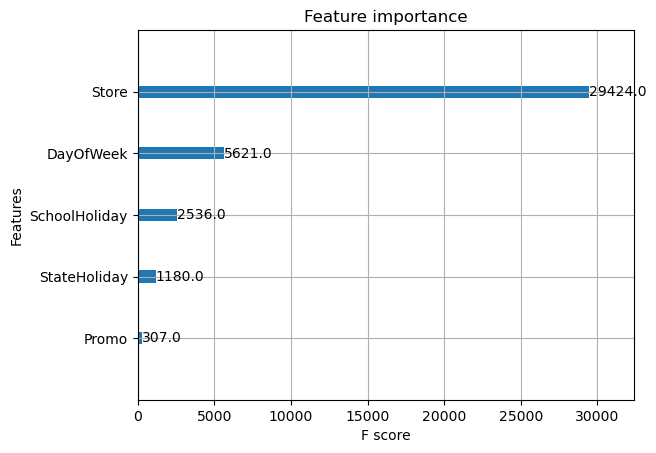

In [13]:
#Print Feature Importance
plt.figure(figsize=(18,8))
from xgboost import plot_importance
plot_importance(model)
plt.show()

In [ ]:
submit = df.loc[df['is_train'] == 0]
dsubmit = xgb.DMatrix(submit[features_x])
predictions = model.predict(dsubmit)

df_predictions = submit['Id'].reset_index()
df_predictions['Id'] = df_predictions['Id'].astype('int')
df_predictions['Sales'] = (np.exp(predictions) - 1) * 0.985 #Scale Back

df_predictions.sort_values('Id', inplace=True)
df_predictions[['Id', 'Sales']].to_csv('solution.csv', index=False)

`Use DVC  dataframes for the second training.`

In [ ]:
# First load the cleaned stores data
data_path = 'data/cleaned/store.csv'
version = 'store_v2'
repo = '../'

store_df = dvc_load.dvc_get_data(data_path, version, repo)

# Then load the raw sales data
data_path = 'data/merged/train.csv'
version = 'train_v2'
repo = '../'

train_df = dvc_load.dvc_get_data(data_path, version, repo)

# Finally load the test data
data_path = 'data/merged/test.csv'
version = 'test_v2'
repo = '../'

test_df = dvc_load.dvc_get_data(data_path, version, repo)